<a href="https://colab.research.google.com/github/phipyao/ds3001-project_voting/blob/main/project_voting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project #3 - Project Voting

## Research question
Which party is predicted to win the state of Virginia the 2024 election?
What party will Virginia specific counties vote for in the 2024 election?

## Summary
We wanted to analyze historical voting data to try to predict the results of the next presential election in Virignia. Being able to predict electoral results is highly useful for campaigns to achieve a better understanding of the current sentiment of voters. This would allow campaigns to efficiently use their resources and target specific areas and voters for a maximal impact. By utilizing this information, campaigns can attempt to increase their odds of winning and fight to push the election in their favor. Although our project only predicts the results in Virginia, the methodology and pipeline can easily be extended to other states as well to predict the outcome of the overall election.

For our model we chose to use an ensemble approach utilizing decision trees. Data was cleaned and reformatted by extracting the necessary vote data and grouping it accordingly by party and year. For our ensemble approach, we utilized a Random Forest model.

Our model predicts that in 2024, the Democratic party will win the popular vote in Virginia. For the regional specific predictions, our model achieved an accuracy of 89.47%. We found that a majority of counties will vote for the Republican candidate but more populous counties tended vote for the Democratic candidate resulting in the popular vote favoring the Democractic candidate. The more populous counties tended to have a very polarizing vote. Fairfax County, Richmond, Arlington County, Norfolk, and Alexandria were the localities that were predicted to be the most Democratic leaning and had some of the highest populations in Virginia. Conversely, Hanover, Chesterfield, Bedford, Augusta, and Virginia Beach were the localities that were predicted to be the most Republican leaning. These counties also had relatively high populations.

# Data

We used three datasets, a shapefile of the Virginia counties which we titled GDF, a table containing rows of the outcomes of each party with the total votes in a given region which we titled VDF, and lastly a table with rows of each region and the regions adjacent to it which was titled CDF. GDF contains 13 columns, most of which define the geometry of the corresponding region. It also contains the FIPS of the region which is a unique identifier we will later use to merge with the other datasets. VDF contains 13 columns as well. The ones we will focus on for this one are county_fips, party, and candidatevotes though the whole table will be merged. CDF has 16 columns though not every column is useful because some regions do not have as many neighbours as others so many cells are NaN. This dataset also contains the virginia district of a given region. As stated previously, in order to use this data we need to transform it slightly and combine them together.

In [5]:
import geopandas as gpd
import mapclassify
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import tree
from mpl_toolkits.axes_grid1 import make_axes_locatable

from sklearn.ensemble import RandomForestRegressor

We begin by importing like normal, though we use the geopandas library here to read the shx file which we haven't used previously.

In [6]:
gdf = gpd.read_file('./va_admin_bndry/VirginiaCounty_ClippedToShoreline.shx')
vdf = pd.read_csv('./data/voting_VA.csv')
cdf = pd.read_csv('./data/county_adjacencies.csv')

We start by merging CDF on to GDF using the FIPS column. This column for GDF had to be created as the given column wasn't of numeric type.

In [7]:
gdf['FIPS_left'] = pd.to_numeric(gdf['STCOFIPS'])
df = gdf.merge(cdf,left_on='FIPS_left',right_on='FIPS')

The next transformation we must do is take each unique year in VDF (the end of each election term i.e. 2000, 2004, ...) and sum the total number of democratic and republicans votes over each region. This is recorded on our main dataframe df as a column either dem_votes_{year} or rep_votes_{year}.

In [8]:
for y in vdf['year'].unique():
    df20 = vdf.loc[ vdf['year']==y,:]

    Dvotes = df20.loc[(df20['party']=='DEMOCRAT'),:].groupby('county_fips')['candidatevotes'].sum()
    Dvotes = Dvotes.rename('dem_votes_' + str(y))
    df = df.merge(Dvotes,left_on='FIPS_left',right_on='county_fips')

    Rvotes = df20.loc[(df20['party']=='REPUBLICAN'),:].groupby('county_fips')['candidatevotes'].sum()
    Rvotes = Rvotes.rename('rep_votes_' + str(y))
    df = df.merge(Rvotes,left_on='FIPS_left',right_on='county_fips')

Next, we defined a helper function that easily extracts the votes for all years for a given region. We will use this later when creating our ensamble.

In [9]:
#cleans data by extracting votes by year for each county
def extract_df(index):
    row = df.iloc[index]
    years = []
    dem_votes = []
    rep_votes = []

    for column in df.columns:
        if column.startswith('dem_votes'):
            year = column.split('_')[-1]
            years.append(year)
            dem_votes.append(row[column])
            rep_votes.append(row['rep_votes_' + year])

    result_df = pd.DataFrame({'dem_votes': dem_votes, 'rep_votes': rep_votes})
    result_df['vote_diff'] = result_df['rep_votes']-result_df['dem_votes']
    return result_df


# Results

## Ensemble

In [10]:
def ensemble(df):
    # Split data into training rows and testing rows:
    N = df.shape[0]
    df = df.sample(frac=1, random_state=100) # randomize the order in which data appears
    train_size = int(.8*N)
    df_train = df[0:train_size]
    N_train = df_train.shape[0]
    df_test = df[train_size:]
    N_test = df_test.shape[0]

    # Bootstrap:
    T = 300
    m_depth = 4
    Rsq = np.zeros(T) # preallocate the rsq measure
    y_test_hat = np.zeros([T,N_test]) # preallocate predictions on test set
    df_train.head()

    # Split data into train/test:
    X_train = df_train.drop(['vote_diff'],axis=1)
    y_train = df_train['vote_diff']
    X_test = df_test.drop(['vote_diff'],axis=1)
    y_test = df_test['vote_diff']

    for s in range(T):
        # Generate a bootstrap sample:
        df_s = df_train.sample(frac=1, replace=True)
        X_s = df_s.drop('vote_diff',axis=1)
        y_s = df_s['vote_diff']
        # Fit decision tree:
        cart = tree.DecisionTreeRegressor(max_depth=m_depth) # Create a classifier object
        cart = cart.fit(X_s, y_s) # Fit the classifier
        # Compute Rsq:
        y_hat = cart.predict(X_test)
        SSE = np.sum( (y_test-y_hat)**2 )
        TSS = np.sum( (y_test-y_s.mean())**2 )
        Rsq[s] = 1 - SSE/TSS
        # Make and Save Predictions:
        y_test_hat[s,:] = y_hat

    # Ensemble predictor:
    y_hat_ensemble = y_test_hat.mean(axis=0) # Average the columns to get the ensemble prediction
    SSE = np.sum( (y_test-y_hat_ensemble)**2 )
    TSS = np.sum( (y_test-y_train.mean())**2 )
    Rsq_ensemble = 1 - SSE/TSS

    # Classification Accuracy
    total_rows = len(y_test)
    correct_label_count = 0
    for i in range(total_rows):
      if y_test.iloc[i] * y_hat_ensemble[i] > 0:  # Check if signs are the same
          correct_label_count += 1

    return [Rsq_ensemble, y_hat_ensemble.mean(), correct_label_count, total_rows]


Takes the average of all the r-sqared values from each individual ensemble prediction from each county:

In [11]:
results = []
region_accuracy = []

total_rows = 0
total_correct_label = 0

r_avg = 0
total = 0
for i in range(len(df)):
    ensemble_results = ensemble(extract_df(i))
    r_avg += ensemble_results[0]

    total_correct_label += ensemble_results[2]
    total_rows += ensemble_results[3]

    accuracy = ensemble_results[2] / ensemble_results[3]
    region_accuracy.append((df.loc[i, 'NAME'], accuracy))

    results.append(ensemble_results)
    total += 1

total_accuracy = total_correct_label / total_rows
r_avg /= total
print(r_avg)

0.19495285938598397


## Extracting Results

In [12]:
# Printing results used by manually comparing predicted labels and the winner they predict to actual
print(f'Classification Accuracy: {total_accuracy * 100}%')

for i in region_accuracy:
  print(f'{i[0]}: {i[1] * 100}%')

Classification Accuracy: 89.84962406015038%
Accomack: 100.0%
Albemarle: 50.0%
Alleghany: 100.0%
Amelia: 100.0%
Amherst: 100.0%
Appomattox: 100.0%
Arlington: 100.0%
Augusta: 100.0%
Bath: 100.0%
Bedford: 100.0%
Bland: 100.0%
Botetourt: 100.0%
Brunswick: 100.0%
Buchanan: 100.0%
Buckingham: 100.0%
Campbell: 100.0%
Caroline: 50.0%
Carroll: 100.0%
Charles City: 100.0%
Charlotte: 100.0%
Chesterfield: 50.0%
Clarke: 100.0%
Craig: 100.0%
Culpeper: 100.0%
Cumberland: 100.0%
Dickenson: 50.0%
Dinwiddie: 100.0%
Essex: 50.0%
Fairfax: 50.0%
Fauquier: 100.0%
Floyd: 100.0%
Fluvanna: 100.0%
Franklin: 100.0%
Frederick: 100.0%
Giles: 100.0%
Gloucester: 100.0%
Goochland: 100.0%
Grayson: 100.0%
Greene: 100.0%
Greensville: 100.0%
Halifax: 100.0%
Hanover: 100.0%
Henrico: 50.0%
Henry: 100.0%
Highland: 100.0%
Isle of Wight: 100.0%
James City: 50.0%
King and Queen: 100.0%
King George: 100.0%
King William: 100.0%
Lancaster: 100.0%
Lee: 100.0%
Loudoun: 100.0%
Louisa: 100.0%
Lunenburg: 100.0%
Madison: 100.0%
Mathews

It was found that over all the regions, the ultimate outcome (either Democrat or Republic) was predicted correct 89.47% of the time across the samples of  random years and regions created in our test set. We also included a breakdown of how the model performed with the accuracies of each individual region. It should be noted that because our data set was very small looking at a given region (six total years split into training set of size four and test set of size two), the individual accuracies can only be three distinct values: 0%, 50%, or 100%.

In [13]:
def ensemble_result(i):
    return ensemble(extract_df(i))[1]

In [14]:
df['predicted_vote_diff'] = df.index.map(ensemble_result)

We discretized Democrat and Republican votes, then taken with inverse hyperbolic sine of the predicted difference to deal with outliers. We also used the inverse hyperbolic sine to help normalize the wide spread of the locality population distribution.

In [18]:
df['vote_diff_ihs'] = np.arcsinh(df['predicted_vote_diff'])     # predicted vote differences
df['population_ihs'] = np.arcsinh(df['Population2022'])         # locality populations

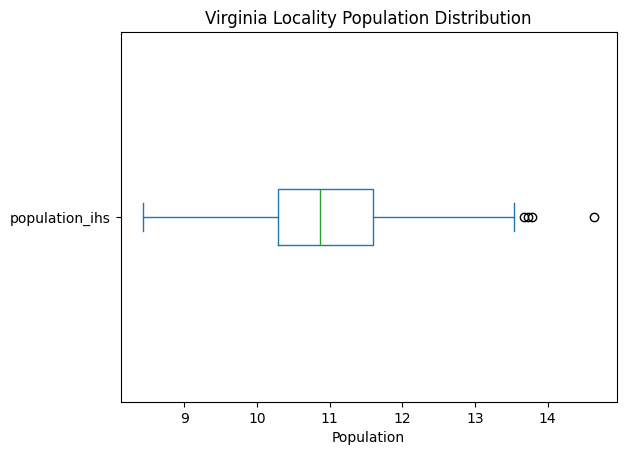

In [19]:
df['population_ihs'].plot.box(vert=False)
plt.title("Virginia Locality Population Distribution")
plt.xlabel("Population")
plt.show()

In [20]:
# Predicted most Democratic leaning counties
df[["NAME", "population_ihs", "vote_diff_ihs"]].sort_values(by=['vote_diff_ihs']).head(5)

,NAME,population_ihs,vote_diff_ihs
28,Fairfax,14.638221,-12.433920
124,Richmond,13.036348,-11.578325
6,Arlington,13.056224,-11.520178
118,Norfolk,13.051919,-11.121225
95,Alexandria,12.647709,-11.090384


In [22]:
# Predicted most Republican leaning counties
df[["NAME", "population_ihs", "vote_diff_ihs"]].sort_values(by=['vote_diff_ihs'], ascending=False).head(5)

,NAME,population_ihs,vote_diff_ihs
41,Hanover,12.327741,10.626501
20,Chesterfield,13.536875,10.514261
9,Bedford,11.993473,10.405527
7,Augusta,11.958431,10.350220
78,Rockingham,12.048213,10.272762


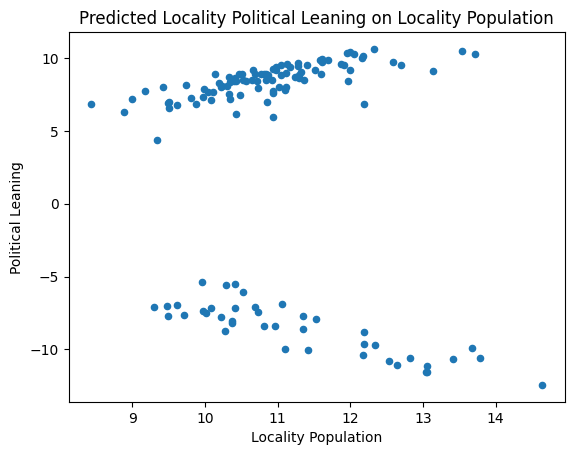

In [21]:
df.plot.scatter(y='vote_diff_ihs', x='population_ihs')
plt.title("Predicted Locality Political Leaning on Locality Population")
plt.xlabel("Locality Population")
plt.ylabel("Political Leaning")
plt.show()

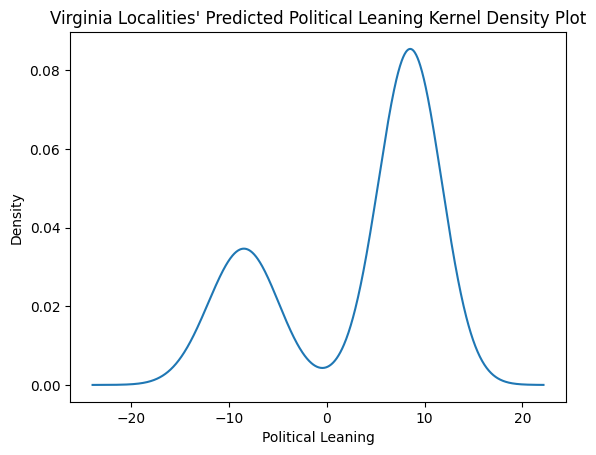

In [23]:
df["vote_diff_ihs"].plot.density()
plt.title("Virginia Localities' Predicted Political Leaning Kernel Density Plot")
plt.xlabel('Political Leaning')
plt.show()

Text(0.5, 1.0, 'Predicted Political Party Leaning in Virginia')

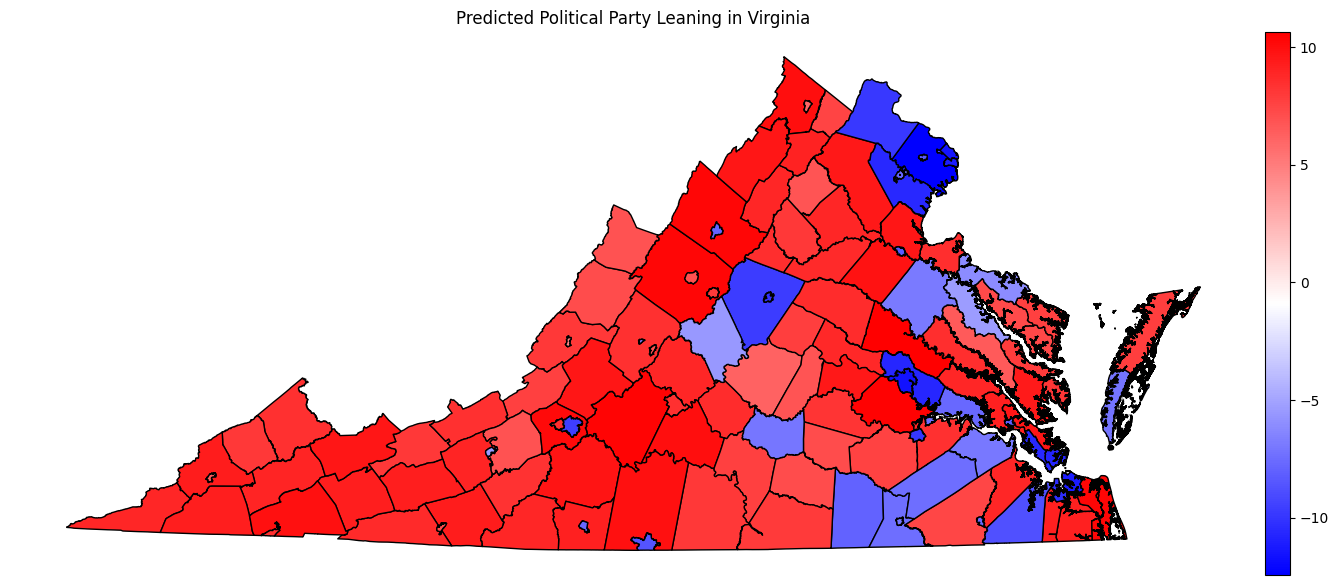

In [24]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 2, 2])
divider = make_axes_locatable(ax)
ax.axis('off')
cax = divider.append_axes("right", size="2%", pad=0.08)
df.plot(ax=ax,column='vote_diff_ihs',legend=True,cax=cax,cmap='bwr',edgecolor='k')

ax.set_title("Predicted Political Party Leaning in Virginia")

In [25]:
# compare which party will win based on which has a greater population of votes
dem_pop = 0
rep_pop = 0

for index, row in df.iterrows():
    if row['vote_diff_ihs'] > 0:
        rep_pop += row['Population2022']
    else:
        dem_pop += row['Population2022']

print(f"Predicted population of Democratic party voters: {dem_pop}")
print(f"Predicted population of Republican party voters: {rep_pop}")

Predicted population of Democratic party voters: 4524470
Predicted population of Republican party voters: 4159160


The Democratic candidate is predicted to win since the population of voters for the Democratic party is higher than the population for the Republican party.

# Conclusion

Although our model did not perform the best on our test data, we were still able to create a prediction for the upcoming 2024 election using machine learning and analysis. It should be noted that the performance metric we chose, the R-squared value of the predicted vs. actual voting differential between a Democratic candidate and a Republican candidate, doesn’t reflect the accuracy of our classifications of each state. The value is low but this only means that the voting differential between parties wasn’t the most accurate, and not necessarily the predicted outcome. Our classification accuracy did show better results with an accuract of nearly 90%. So while we can't be assured that the predicted differentials will be accurate, we can be relatively confident in our generated map and results of the 2024 election with more evidence to back it up.

If we were to continue building on this project, we would try different analytic methods and use more relevant performance measures. Because we’re predicting the results of a future election, we don’t have a test set to validate against, and thus how we compare to past data is very important to ensuring confidence in our results for 2024. This can easily be misrepresented by a lack of data or improper analysis so to continue would be to evaluate many different performance metrics and discuss how they may or may not fit the research question better. One method may tell us our model performs better in predicting one particular area (like the number of people who ultimately vote) but misrepresent another area (like the ultimate voting outcome).

There are still many flaws with our model. Analyzing only historical data fails to account for any cultural changes or evolution of views over time as values in society change. This is apparent even in the window of time this project uses as Virginia appears to change from republican leaning to democratic leaning. We believe that a potentially good approach for this placing some sort of greater bias on more recent years as these are likely to be the closest to reflecting the views of people in the present.

Another major limitation of this model is that there is no consideration of the candidates as personalities or their platforms. This would likely have a significant impact on re-elections. After a term in office voters are more likey to be influenced by how effective they deem the candidate to have been. This would shift the focus away from just party leanings and historical votes which would make our model less effective as a predictor. Additionally, if there was data on what voters from previous years considered to be important, we believe that it would also be beneficial to have a greater bias on more recent elections to highlight the problems that are likely important to current voters.
